Download the Colab

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !git clone --branch vectorization-change https://github.com/Ostailor/QViT_HEP_ML4Sci.git

Cloning into 'QViT_HEP_ML4Sci'...
remote: Enumerating objects: 316, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 316 (delta 38), reused 2 (delta 2), pack-reused 252 (from 1)
Receiving objects: 100% (316/316), 3.32 MiB | 10.78 MiB/s, done.
Resolving deltas: 100% (172/172), done.


Install dependencies to run the code

In [ ]:
!pip install tensorcircuit
!pip install pennylane
!pip install -U qiskit
!pip install -U cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.0/342.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━

Import all the required packages. Also if you have access to a GPU then switch device='cpu' to device='cuda'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import math
from tqdm.notebook import tqdm
import time
from torchvision.datasets import MNIST
from torchvision import transforms
import h5py
if IN_COLAB: from QViT_HEP_ML4Sci.QViT import *
else: from QViT import *
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix

torch.set_default_dtype(torch.float32)
torch.set_num_threads(8)
device='cpu' # technically algorithm can be run on cpu but for speed reasons, it is not suggested.

To make the circuits look better.

In [ ]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
})

Download the MNIST data set.

In [ ]:
mnist_trainset = MNIST(root='./data', train=True, download=True)
n,d= 7,28

transform = transforms.Compose([ transforms.Resize((14,14)), transforms.ConvertImageDtype(torch.float64),transforms.Normalize(0,1)])
data = mnist_trainset.data

data = transform(data)


data_patched = patcher(data,[2,14])
mnist_trainset = simple_dataset(data_patched,mnist_trainset.targets)
tr_len = 4000
val_len = 1000
tr_set,val_set,test_set = torch.utils.data.random_split(mnist_trainset,[tr_len,val_len,mnist_trainset.target.shape[0]-tr_len-val_len])
tr_dl = DataLoader(tr_set,batch_size=32,shuffle=True)
val_dl = DataLoader(val_set,batch_size=32,shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 50.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.26MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.06MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Transformer_dims:

    Token_Dim: Dimension of each token's embedding, inferred from the second-to-last dimension of data_patched.

    Image_Dim: Dimension related to image data, inferred from the last dimension of data_patched.

Transformer_hyper:

    n_layers: Number of Transformer encoder layers (set to 2).

    FC_layers: List defining the sizes of fully connected layers in the classifier ([64, 32]).

    head_dimension: Number of attention heads (set to 4).

    mbed_Dim: Embedding dimension for tokens (set to 32).

    ff_dim: Feedforward network dimension within encoder layers (set to 32).

Transformer_type:

    classifying_type: Method of aggregating Transformer outputs for classification (set to 'max' pooling)

    pos_embedding: Boolean indicating whether to use positional embedding

In [ ]:
transformer_dims = {'Token_Dim':data_patched.shape[-2],'Image_Dim':data_patched.shape[-1]}
transformer_hyper = {'n_layers':2,'FC_layers':[64, 32],
                    'head_dimension':4,'Embed_Dim': 32,'ff_dim':32}
transformer_type = {'classifying_type':'max','pos_embedding':True}

Using hybrid2 as it uses the quantum circuit.

There are classic, hybrid1, hybrid2.



In [ ]:
model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='hybrid2').to(device)

It is possible to increase n_epochs to 100 if you have access to a gpu but 10 epochs prove to be enough for 85% training and validation accuracy.

In [ ]:
optim = torch.optim.Adam(model.parameters(),lr=1e-3)
n_epochs = 10 # Using only 10 epochs because of no gpu. This is the test with the updated circuit.
loss_fn = nn.CrossEntropyLoss(reduction='none')
history = train(model,tr_dl,val_dl,loss_fn,optim,n_epochs,device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Plot loss and accuracy and the wrongly predicted ratio which is 16%.

<ipython-input-10-a070957aaaca>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_state_on_training_acc'))
<ipython-input-10-a070957aaa

# of parameters: 10160
Wrongly Predicted Ratio:0.15800000727176666


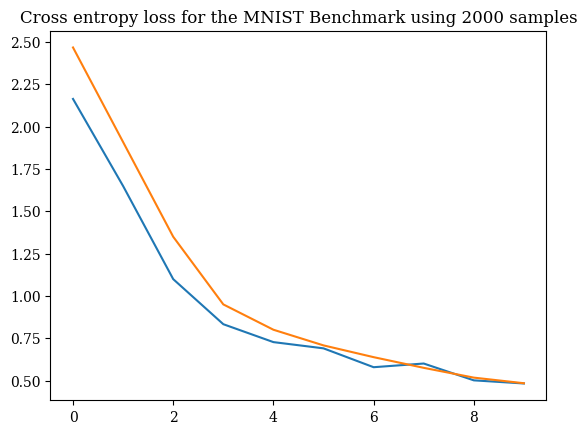

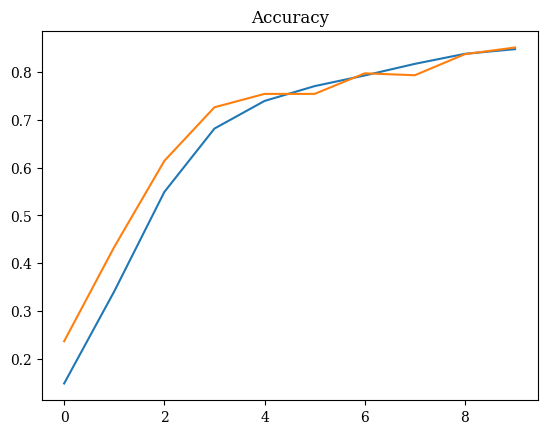

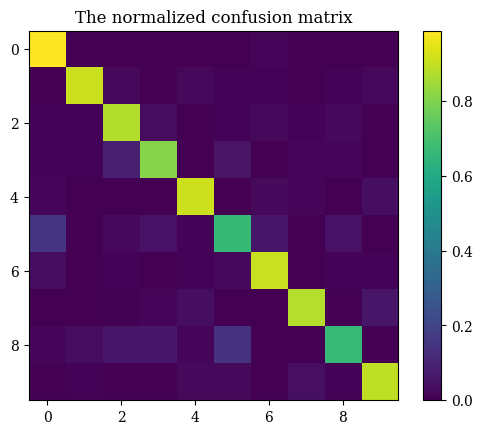

In [ ]:
model.load_state_dict(torch.load('best_state_on_training_acc'))
print(f'# of parameters: {sum([np.prod(i.shape) for i in model.parameters()])}')
history = torch.load('temp_history')
plt.plot(history['val'],label='val_loss')
plt.plot(history['tr'],label='tr_loss')
plt.title('Cross entropy loss for the MNIST Benchmark using 2000 samples')
plt.figure()
plt.plot(history['tr_acc'],label='val')
plt.plot(history['val_acc'],label='tr')
plt.title('Accuracy')
plt.figure()
with torch.no_grad():pred = model(test_set.dataset.data[test_set.indices[:1000]].to(device)).cpu().argmax(axis=1)
plt.imshow(confusion_matrix(pred.cpu(),test_set.dataset.target[test_set.indices[:1000]],normalize='true'))
plt.colorbar()
plt.title('The normalized confusion matrix')
print(f'Wrongly Predicted Ratio:{ (pred != test_set.dataset.target[test_set.indices[:1000]]).sum()/pred.shape[0]}')